# CAPSTONE PROJECT 2
Menganalisa data dari NYC TLC Trip Record.csv
Dari data tersebut, saya ingin:
1. Melakukan Exploratory data analysis (EDA) dari kumpulan data.
2. Jika setiap supir taksi hanya dapat ditempatkan di satu lokasi penjemputan, manakah yang direkomendasikan?

In [ ]:
!pip install autoviz

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import plotly.express as px
from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [6]:
df = pd.read_csv("/content/NYC TLC Trip Record.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               68211 non-null  int64  
 1   lpep_pickup_datetime   68211 non-null  object 
 2   lpep_dropoff_datetime  68211 non-null  object 
 3   store_and_fwd_flag     63887 non-null  object 
 4   RatecodeID             63887 non-null  float64
 5   PULocationID           68211 non-null  int64  
 6   DOLocationID           68211 non-null  int64  
 7   passenger_count        63887 non-null  float64
 8   trip_distance          68211 non-null  float64
 9   fare_amount            68211 non-null  float64
 10  extra                  68211 non-null  float64
 11  mta_tax                68211 non-null  float64
 12  tip_amount             68211 non-null  float64
 13  tolls_amount           68211 non-null  float64
 14  ehail_fee              0 non-null      float64
 15  im

In [7]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,N,1.0,166,143,1.0,2.58,14.9,1.0,0.5,4.03,0.0,NaN,1.0,24.18,1.0,1.0,2.75
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,N,1.0,24,43,1.0,1.81,10.7,1.0,0.5,2.64,0.0,NaN,1.0,15.84,1.0,1.0,0.00
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,N,1.0,223,179,1.0,0.00,7.2,1.0,0.5,1.94,0.0,NaN,1.0,11.64,1.0,1.0,0.00
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,N,1.0,41,238,1.0,1.30,6.5,0.5,1.5,1.70,0.0,NaN,1.0,10.20,1.0,1.0,0.00
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,N,1.0,41,74,1.0,1.10,6.0,0.5,1.5,0.00,0.0,NaN,1.0,8.00,1.0,1.0,0.00


* Dapat kita lihat beberapa karakteristik penting dari Taxi Trip seperti:
> 1. Trip Distance
> 2. Passanger count
> 3. Lokasi pick up dan drop off
> 4. Tipe pembayaran
> 5. store_and_fwd_flag: apakah catatan perjalanan disimpan dalam memori kendaraan sebelum dikirim ke vendor atau tidak.
> 6. Rate Code ID
> 7. Semua jenis harga: **fare amount**, **extra**, **mta tax**, **tip_amount**, **tolls_amount**, **improvement surcharge**, **total amount**

* Fitur tambahan:
> Kita dapat dengan mudah menghitung durasi perjalanan menggunakan pengurangan sederhana dari waktu penjemputan dengan waktu pengantaran

## Missing Value

In [8]:
# persentase missing value di tiap kolom
df.isna().sum()/df.shape[0]*100

VendorID                   0.000000
lpep_pickup_datetime       0.000000
lpep_dropoff_datetime      0.000000
store_and_fwd_flag         6.339154
RatecodeID                 6.339154
PULocationID               0.000000
DOLocationID               0.000000
passenger_count            6.339154
trip_distance              0.000000
fare_amount                0.000000
extra                      0.000000
mta_tax                    0.000000
tip_amount                 0.000000
tolls_amount               0.000000
ehail_fee                100.000000
improvement_surcharge      0.000000
total_amount               0.000000
payment_type               6.339154
trip_type                  6.353814
congestion_surcharge       6.339154
dtype: float64

Dari data diatas:
* missing value di kolom `ehail_fee` mencapai 100%, artinya seluruh baris atau kolom dalam file tersebut tidak memiliki nilai yang valid. Dalam situasi ini, data tersebut tidak akan memberikan informasi yang berguna dan biasanya tidak perlu diproses lebih lanjut.

In [9]:
# Menghapus kolom ehail_fee
df = df.drop('ehail_fee', axis=1)


# DATA CLEANING

Mengonversi waktu pick up dan drop off time menjadi waktu tanggal

In [10]:
df["lpep_pickup_datetime"] = pd.to_datetime(df.lpep_pickup_datetime)
df["lpep_dropoff_datetime"] = pd.to_datetime(df.lpep_dropoff_datetime)

Menghitung trip duration dalam hitungan detik, karena itu adalah satuan waktu yang paling rinci dalam kasus ini

In [11]:
df["trip_duration_seconds"] = (df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]).astype('timedelta64[s]')

In [12]:
df["trip_duration_seconds"]

0         661.0
1         406.0
2         380.0
3         349.0
4         358.0
          ...  
68206     780.0
68207     480.0
68208     960.0
68209    1080.0
68210     960.0
Name: trip_duration_seconds, Length: 68211, dtype: float64

Beberapa fitur yang bisa ditambah:
* Flag variable untuk pagi atau malam
* Category variable untuk menunjuk hari apa pada minggu tersebut

In [13]:
df['daytime_flag'] = (df["lpep_pickup_datetime"].dt.hour > 5) & (df["lpep_pickup_datetime"].dt.hour < 18)
df['daytime_flag'] = pd.Categorical(df['daytime_flag'])

Kita harus mencatat hari dalam seminggu, karena mungkin berhubungan dengan fitur seperti durasi waktu atau jarak.

Untuk itu, dibuat fitur kategorikal baru dengan nilai 0-6: Senin=0, Minggu=6.

In [14]:
df["pickup_weekday"] = df["lpep_pickup_datetime"].dt.dayofweek
df["pickup_weekday"] = pd.Categorical(df["pickup_weekday"] )

Melihat apakah masih ada yang perlu dilakukan data cleaning

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               68211 non-null  int64         
 1   lpep_pickup_datetime   68211 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  68211 non-null  datetime64[ns]
 3   store_and_fwd_flag     63887 non-null  object        
 4   RatecodeID             63887 non-null  float64       
 5   PULocationID           68211 non-null  int64         
 6   DOLocationID           68211 non-null  int64         
 7   passenger_count        63887 non-null  float64       
 8   trip_distance          68211 non-null  float64       
 9   fare_amount            68211 non-null  float64       
 10  extra                  68211 non-null  float64       
 11  mta_tax                68211 non-null  float64       
 12  tip_amount             68211 non-null  float64       
 13  t

Saya ingin mengonversi vendorID, payment type, store_and_fwd_flag, RatecodeID, and pickup_weekday menjadi variabel kategori

In [16]:
df['VendorID'] = pd.Categorical(df.VendorID)
df['RatecodeID'] = pd.Categorical(df.RatecodeID)
df['payment_type'] = pd.Categorical(df.payment_type)

In [17]:
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N':0,'Y':1})
df['store_and_fwd_flag'] = pd.Categorical(df.store_and_fwd_flag)

Saya memutuskan untuk memperlakukan lokasi pick up dan drop off sebagai variabel kategori. Karena bukan numerik dan bukan ID non-duplikat, jadi tidak bertindak sebagai jenis ID primer, tetapi lebih sebagai flag variable.

In [18]:
df['PULocationID'] = pd.Categorical(df.PULocationID)
df['DOLocationID'] = pd.Categorical(df.DOLocationID)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68211 entries, 0 to 68210
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               68211 non-null  category      
 1   lpep_pickup_datetime   68211 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  68211 non-null  datetime64[ns]
 3   store_and_fwd_flag     63887 non-null  category      
 4   RatecodeID             63887 non-null  category      
 5   PULocationID           68211 non-null  category      
 6   DOLocationID           68211 non-null  category      
 7   passenger_count        63887 non-null  float64       
 8   trip_distance          68211 non-null  float64       
 9   fare_amount            68211 non-null  float64       
 10  extra                  68211 non-null  float64       
 11  mta_tax                68211 non-null  float64       
 12  tip_amount             68211 non-null  float64       
 13  t

In [20]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_duration_seconds,daytime_flag,pickup_weekday
0,2,2023-01-01 00:26:10,2023-01-01 00:37:11,0.0,1.0,166,143,1.0,2.58,14.9,...,4.03,0.0,1.0,24.18,1.0,1.0,2.75,661.0,False,6
1,2,2023-01-01 00:51:03,2023-01-01 00:57:49,0.0,1.0,24,43,1.0,1.81,10.7,...,2.64,0.0,1.0,15.84,1.0,1.0,0.00,406.0,False,6
2,2,2023-01-01 00:35:12,2023-01-01 00:41:32,0.0,1.0,223,179,1.0,0.00,7.2,...,1.94,0.0,1.0,11.64,1.0,1.0,0.00,380.0,False,6
3,1,2023-01-01 00:13:14,2023-01-01 00:19:03,0.0,1.0,41,238,1.0,1.30,6.5,...,1.70,0.0,1.0,10.20,1.0,1.0,0.00,349.0,False,6
4,1,2023-01-01 00:33:04,2023-01-01 00:39:02,0.0,1.0,41,74,1.0,1.10,6.0,...,0.00,0.0,1.0,8.00,1.0,1.0,0.00,358.0,False,6


# No.1 Exploratory data analysis (EDA)

Di sini saya berencana untuk memplot distribusi variabel, mencari tahu penyebaran data melalui histogram dan mulai mencari hubungan antar variabel.

## Categorical Variable

Pertama kita lihat variabel kategori

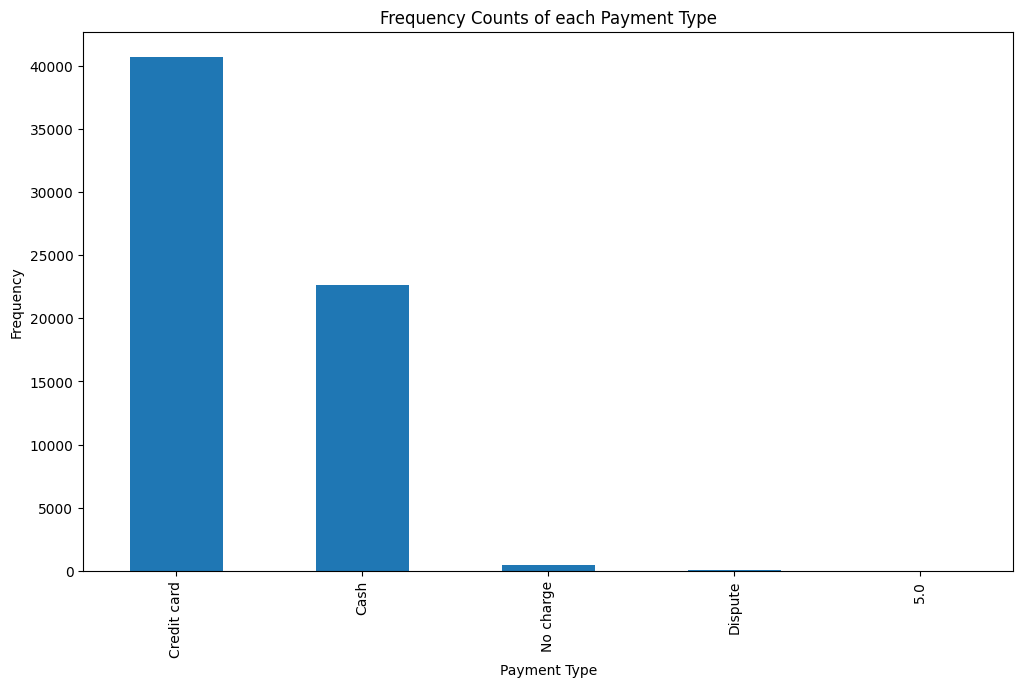

1.0    40686
2.0    22632
3.0      472
4.0       95
5.0        2
Name: payment_type, dtype: int64


In [21]:
plt.ticklabel_format(style = 'plain')

ax = df['payment_type'].value_counts().rename(index={1:"Credit card", 2:"Cash", 3:"No charge", 4:"Dispute"}).plot(kind='bar',
                                    figsize=(12,7),
                                    title="Frequency Counts of each Payment Type")
ax.set_xlabel("Payment Type")
ax.set_ylabel("Frequency")

plt.show()
print(df['payment_type'].value_counts())

Dari gambar diatas:
Kebanyakan transaksi menggunakan **Credit card**, lalu **cash**. Terdapat sedikit **No charge**, dan sangat sedikit **dispute**

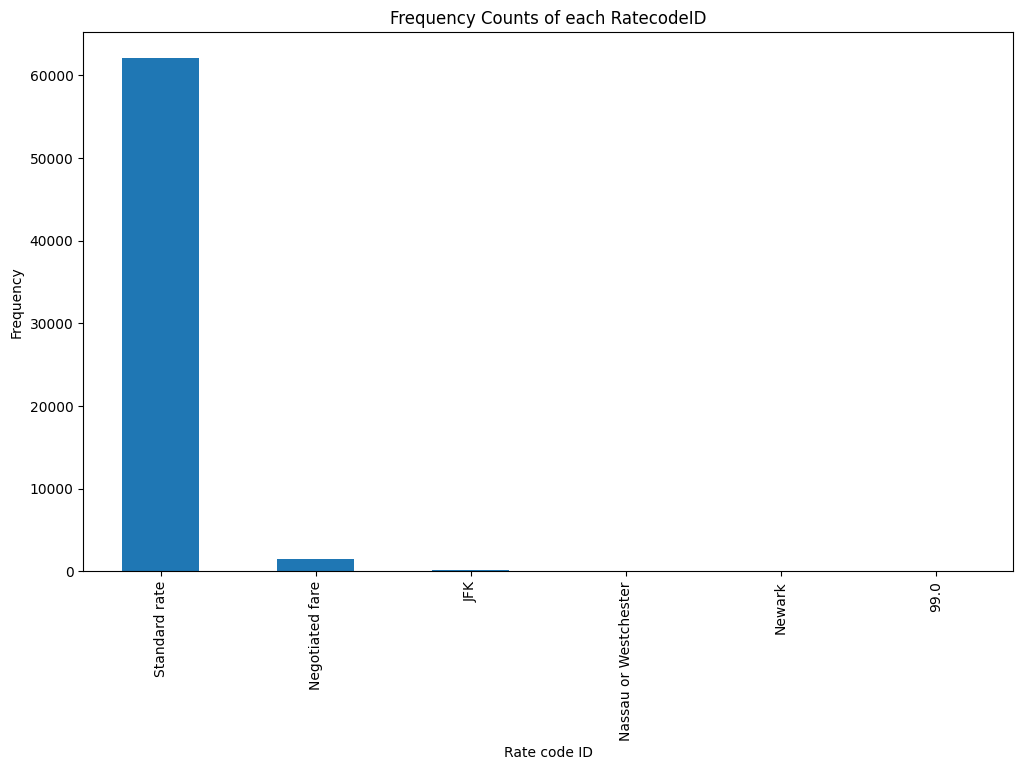

1.0     62103
5.0      1529
2.0       158
4.0        57
3.0        30
99.0       10
Name: RatecodeID, dtype: int64


In [25]:
plt.ticklabel_format(style = 'plain')

translate = {1: "Standard rate", 2: "JFK", 3: "Newark", 4: "Nassau or Westchester", 5: "Negotiated fare"}
ax = df['RatecodeID'].value_counts().rename(index=translate).plot(kind='bar',
                                    figsize=(12,7),
                                    title="Frequency Counts of each RatecodeID")
ax.set_xlabel("Rate code ID")
ax.set_ylabel("Frequency")

plt.show()
print(df['RatecodeID'].value_counts())

* Kode Tarif:
>**1**= Standard rate
>**2**= JFK
>**3**= Newark
>**4**= Nassau or Westchester
>**5**= Negotiated fare
* Interpretasi:
> **Standard rate** (n = 62103), **Negotiated fare** (n = 1529), **JFK** (n = 158), **Nassau or Westchester** (n = 57), **Newark** (n =30), lalu sejumlah porsi kecil dari keseluruhan code. Disini dapat dilihat **Standard rate** sangat sering digunakan



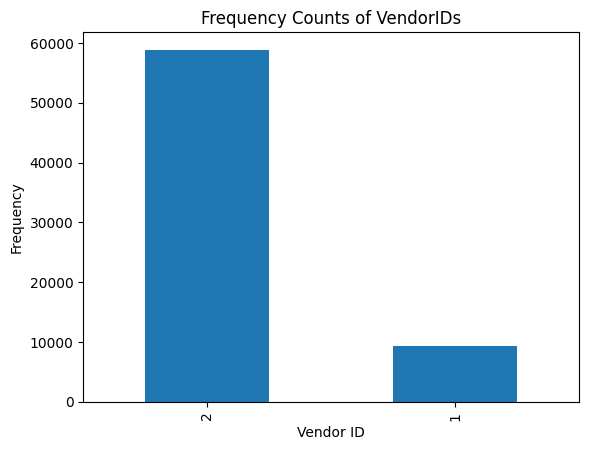

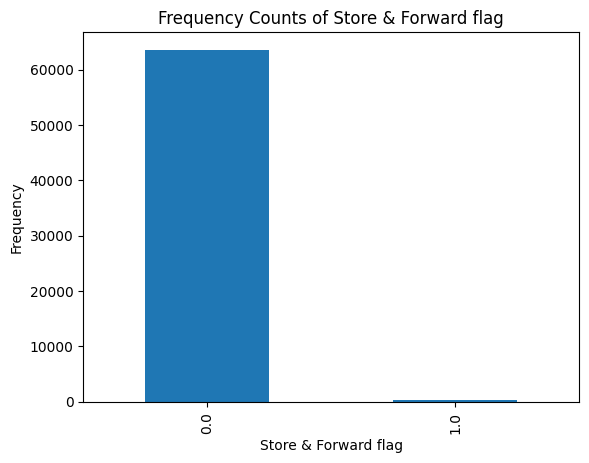

In [26]:
plt.subplots(1, 1)
plt.ticklabel_format(style = 'plain')

ax1 = df['VendorID'].value_counts().plot(kind='bar',
                                    title="Frequency Counts of VendorIDs")
ax1.set_xlabel("Vendor ID")
ax1.set_ylabel("Frequency")

plt.show()

plt.ticklabel_format(style = 'plain')
ax2 = df['store_and_fwd_flag'].value_counts().plot(kind='bar',
                                    title="Frequency Counts of Store & Forward flag")
ax2.set_xlabel("Store & Forward flag")
ax2.set_ylabel("Frequency")

plt.show()

* Interpretasi gambar diatas:
> Provider paling banyak adalah **Vendor ID 2** (lebih dari 50.000 trip), lalu **Vendor ID 1** (hampir 10.000 trip). Selain itu, sebagian besar trip taksi **bukan merupakan store and forward trip**

## Continuous Variable

Selanjutnya kita melihat continuous variable

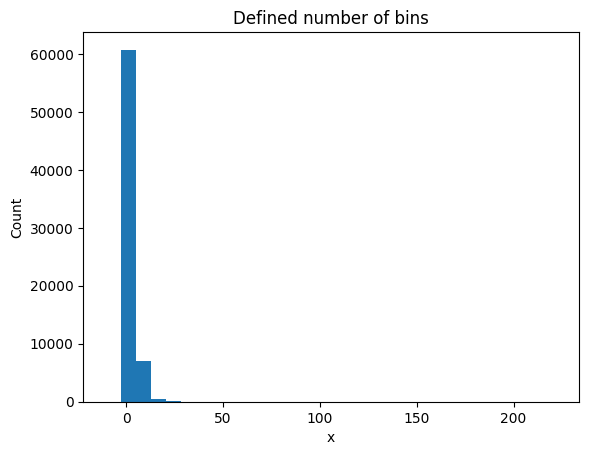

In [27]:
plt.ticklabel_format(style = 'plain')

plt.hist(df.tip_amount, bins = 30)
plt.title ('Defined number of bins')
plt.xlabel ('x')
plt.ylabel ('Count')

plt.show()

Histogram diatas tidak akan memberi tahu kita apa pun tentang data, karena outlier menyeret keluar skala sumbu x, jadi jika  ingin melihat beberapa histogram, saya perlu menyesuaikan rentang x, dan bins.

Mari kita lihat ringkasan statistik dari setiap variabel kontinu untuk menentukan rentang bins.

In [29]:
continuous_lst = ["trip_distance", "passenger_count", "fare_amount", "extra", "mta_tax", "tip_amount",
                  "tolls_amount", "improvement_surcharge", "total_amount", "trip_duration_seconds"]

pd.options.display.float_format = '{:.6f}'.format

df[continuous_lst].describe()

,trip_distance,passenger_count,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration_seconds
count,68211.000000,63887.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000
mean,8.114852,1.315870,16.603545,0.825431,0.588340,2.139012,0.169627,0.951625,21.789377,1085.836243
std,585.105955,0.979054,13.470121,1.269904,0.385819,3.052710,1.099789,0.196875,15.457115,4495.537874
min,0.000000,0.000000,-70.000000,-2.500000,-0.500000,-10.500000,0.000000,-1.000000,-71.500000,0.000000
25%,1.110000,1.000000,9.300000,0.000000,0.500000,0.000000,0.000000,1.000000,12.900000,433.000000
50%,1.850000,1.000000,13.500000,0.000000,0.500000,1.600000,0.000000,1.000000,17.900000,684.000000
75%,3.210000,1.000000,19.800000,1.000000,0.500000,3.330000,0.000000,1.000000,26.150000,1049.000000
max,120098.840000,9.000000,490.000000,12.500000,2.750000,222.220000,36.050000,1.000000,491.000000,86393.000000


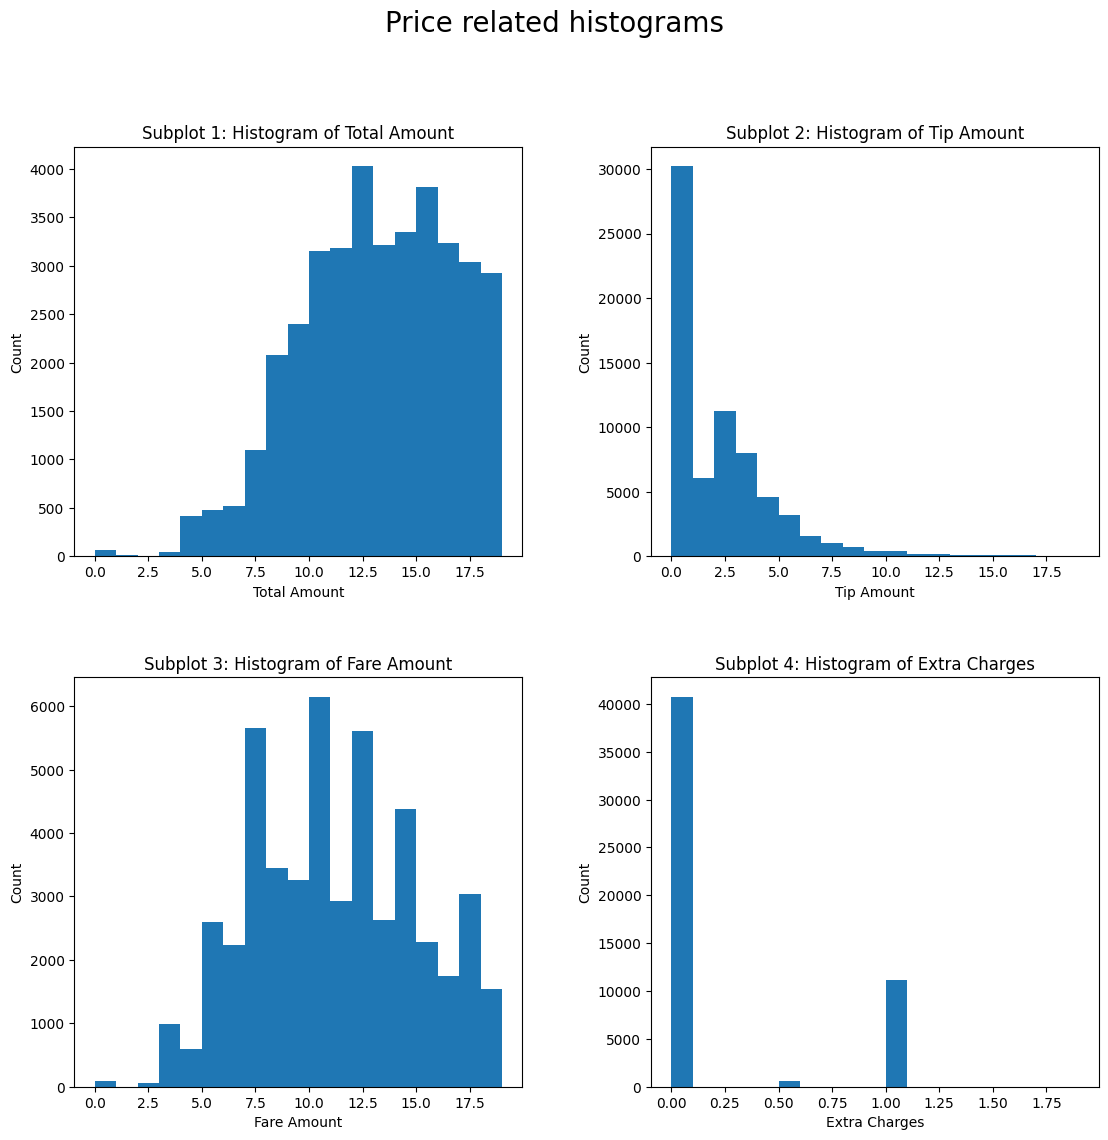

In [30]:
fig = plt.figure(figsize=(12,12))

# Create subplot 1
ax1 = fig.add_subplot(221) # Grid of 2x2, this is suplot 1
ax1.set_xlabel('Total Amount')
ax1.set_ylabel('Count')
ax1.set_title('Subplot 1: Histogram of Total Amount')

ax1 = plt.hist(df.total_amount, bins=np.arange(0,20,1))

# Create subplot 2
ax2 = fig.add_subplot(222) # Grid of 2x2, this is suplot 2
ax2.set_xlabel('Tip Amount')
ax2.set_ylabel('Count')
ax2.set_title('Subplot 2: Histogram of Tip Amount')

ax2 = plt.hist(df.tip_amount, bins=np.arange(0,20,1))

# Create subplot 3
ax3 = fig.add_subplot(223) # Grid of 2x2, this is suplot 3
ax3.set_xlabel('Fare Amount')
ax3.set_ylabel('Count')
ax3.set_title('Subplot 3: Histogram of Fare Amount')

ax3 = plt.hist(df.fare_amount, bins=np.arange(0,20,1))

# Create subplot 4
ax4 = fig.add_subplot(224) # Grid of 2x2, this is suplot 3
ax4.set_xlabel('Extra Charges')
ax4.set_ylabel('Count')
ax4.set_title('Subplot 4: Histogram of Extra Charges')

ax4 = plt.hist(df.extra, bins=np.arange(0,2,0.1))

# Add main title
plt.suptitle('Price related histograms', size = 20)

plt.tight_layout(pad=4)
plt.ticklabel_format(style = 'plain')
plt.show()

Jumlah total tampak dekat dengan kurva berbentuk lonceng, sehingga untuk beberapa analisis ini dapat diasumsikan terdistribusi hampir secara normal.

Catatan, karena **Fare Amount** terkait erat dengan **Total Amount** terlihat hampir terdistribusi secara normal, namun tampaknya ada sedikit kemiringan yang menarik di sisi kanan kurva berbentuk lonceng.

**Tip Amount** miring ke kiri dikarenakan kebanyakan orang tidak memberi tip, lalu semakin sedikit tip yang lebih besar. Jumlah frekuensi tip menurun secara eksponensial saat jumlahnya meningkat.

## Pickup weekday correlations

In [31]:
index_weekday = {0:"Mon", 1:"Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}

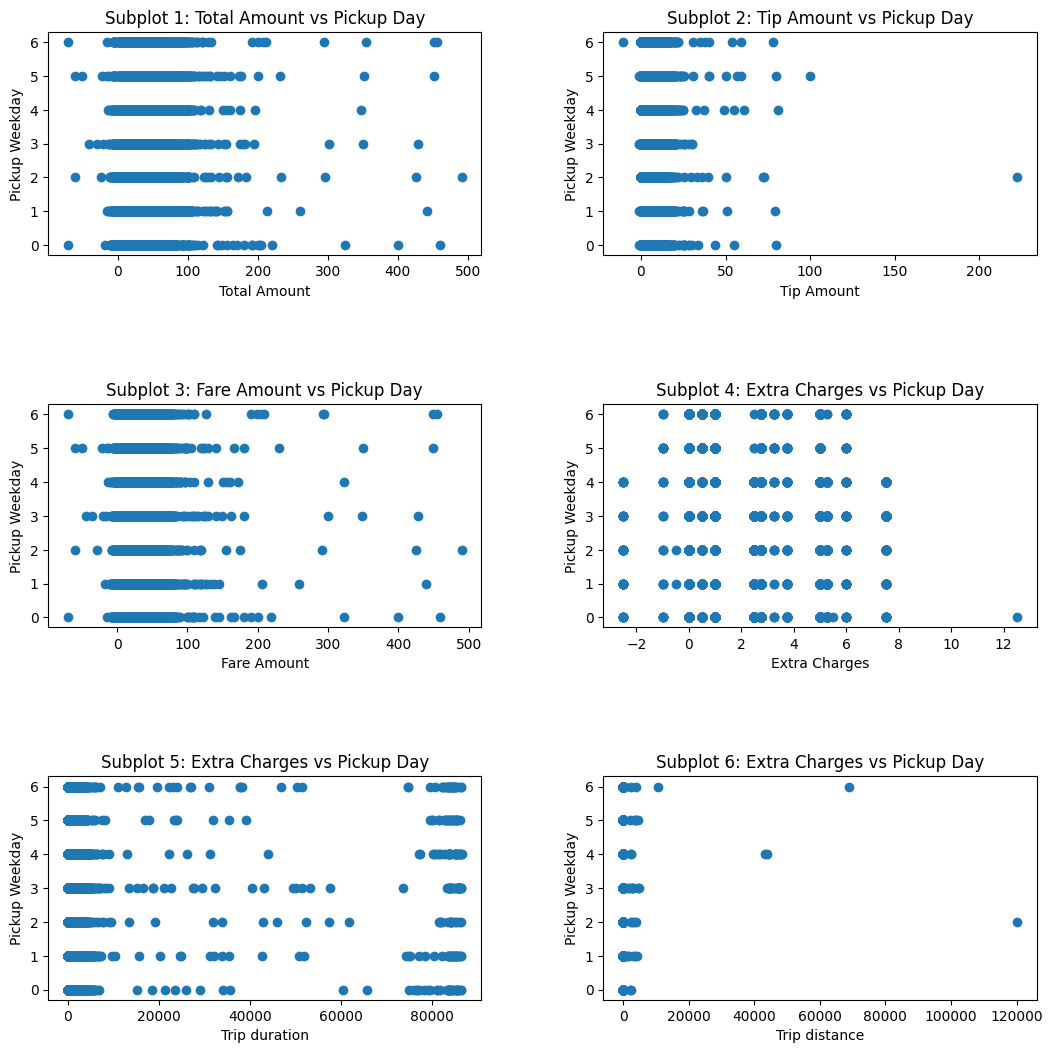

In [33]:
fig = plt.figure(figsize=(12,12))

# Create subplot 1
ax1 = fig.add_subplot(321) #suplot 1
ax1.set_xlabel('Total Amount')
ax1.set_ylabel('Pickup Weekday')
ax1.set_title('Subplot 1: Total Amount vs Pickup Day')

ax1 = plt.scatter(df.total_amount, df.pickup_weekday.rename(index=index_weekday))

# Create subplot 2
ax2 = fig.add_subplot(322) #suplot 2
ax2.set_xlabel('Tip Amount')
ax2.set_ylabel('Pickup Weekday')
ax2.set_title('Subplot 2: Tip Amount vs Pickup Day')

ax2 = plt.scatter(df.tip_amount, df.pickup_weekday.rename(index=index_weekday))

# Create subplot 3
ax3 = fig.add_subplot(323) #suplot 3
ax3.set_xlabel('Fare Amount')
ax3.set_ylabel('Pickup Weekday')
ax3.set_title('Subplot 3: Fare Amount vs Pickup Day')

ax3 = plt.scatter(df.fare_amount, df.pickup_weekday.rename(index=index_weekday))

# Create subplot 4
ax4 = fig.add_subplot(324) #suplot 3
ax4.set_xlabel('Extra Charges')
ax4.set_ylabel('Pickup Weekday')
ax4.set_title('Subplot 4: Extra Charges vs Pickup Day')

ax4 = plt.scatter(df.extra, df.pickup_weekday.rename(index=index_weekday))

# Create subplot 5
ax5 = fig.add_subplot(325) #suplot 3
ax5.set_xlabel('Trip duration')
ax5.set_ylabel('Pickup Weekday')
ax5.set_title('Subplot 5: Extra Charges vs Pickup Day')

#aggr = df.groupby('pickup_weekday').mean()['trip_duration_seconds']

ax5 = plt.scatter(df["trip_duration_seconds"], df.pickup_weekday.rename(index=index_weekday))

# Create subplot 6
ax6 = fig.add_subplot(326) #suplot 3
ax6.set_xlabel('Trip distance')
ax6.set_ylabel('Pickup Weekday')
ax6.set_title('Subplot 6: Extra Charges vs Pickup Day')

#aggr = df.groupby('pickup_weekday').mean()['trip_distance']

ax6 = plt.scatter(df.trip_distance, df.pickup_weekday.rename(index=index_weekday))

plt.tight_layout(pad=6)
plt.ticklabel_format(style = 'plain')
plt.show()

Dari Plot diatas dapat ditarik kesimpulan berikut:
* Hari Rabu dan Sabtu mempunyai **Total Amount** yang tinggi
* Hari Rabu dan Sabtu juga mempunyai **Tip Amount** yang tinggi

## Correlation matrix for the variables


In [34]:
numeric_df = df.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:]

numeric_df.columns

Index(['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount', 'trip_type',
       'congestion_surcharge', 'trip_duration_seconds'],
      dtype='object')

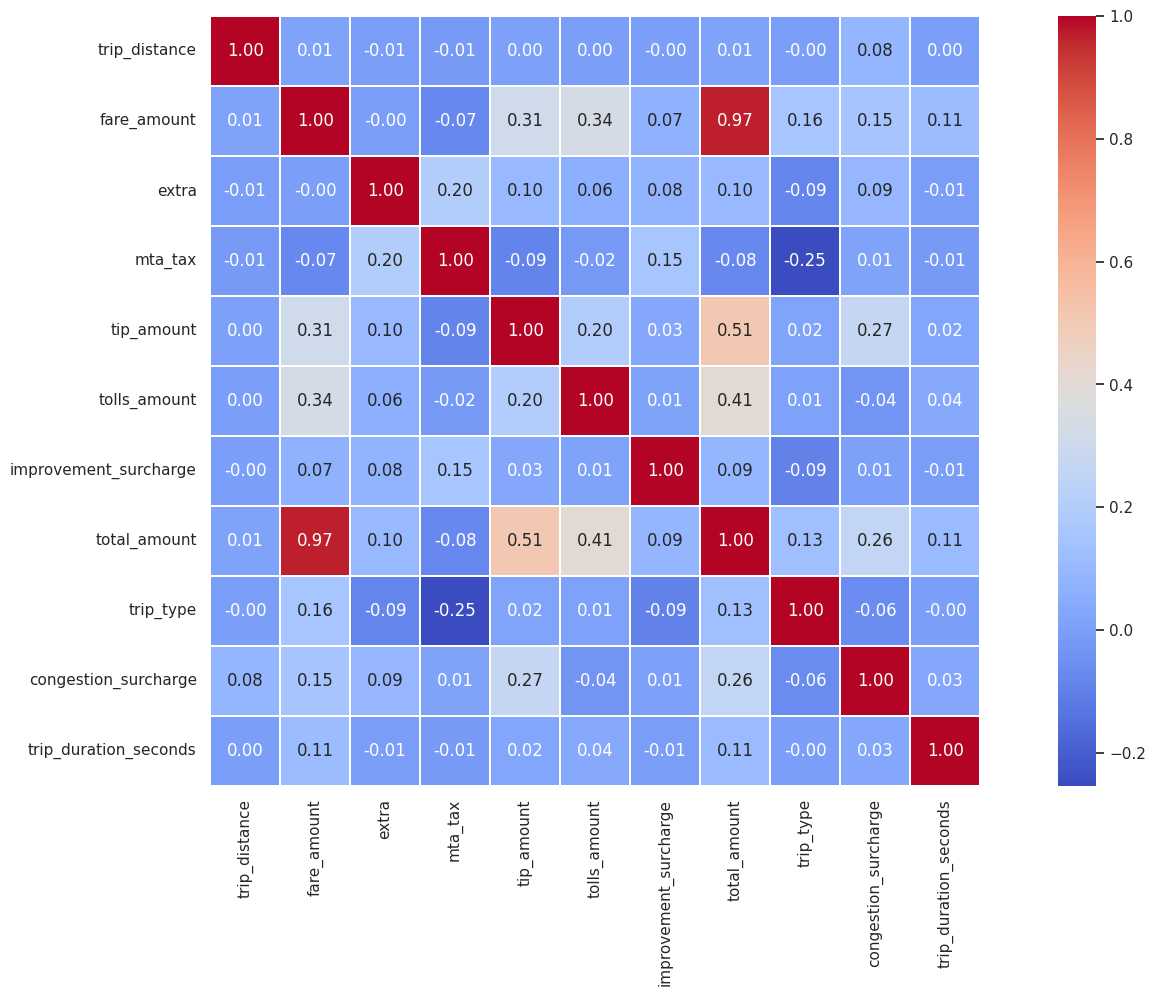

In [35]:
fig = plt.figure(figsize=(20, 10))
sns.set(font_scale=1)
sns.heatmap(numeric_df.corr(), cbar=True, annot=True, square=True,\
                 fmt='.2f',
                 annot_kws={'size': 12}, yticklabels=numeric_df.columns,\
                 xticklabels=numeric_df.columns, cmap = 'coolwarm',lw = .1)
plt.show()

Terdapat korelasi yang tinggi antara:
- Total amount dan fare amount
- Tip amount dan total amount

Oleh karena itu, langkah selanjutnya adalah menghapus **total amount**

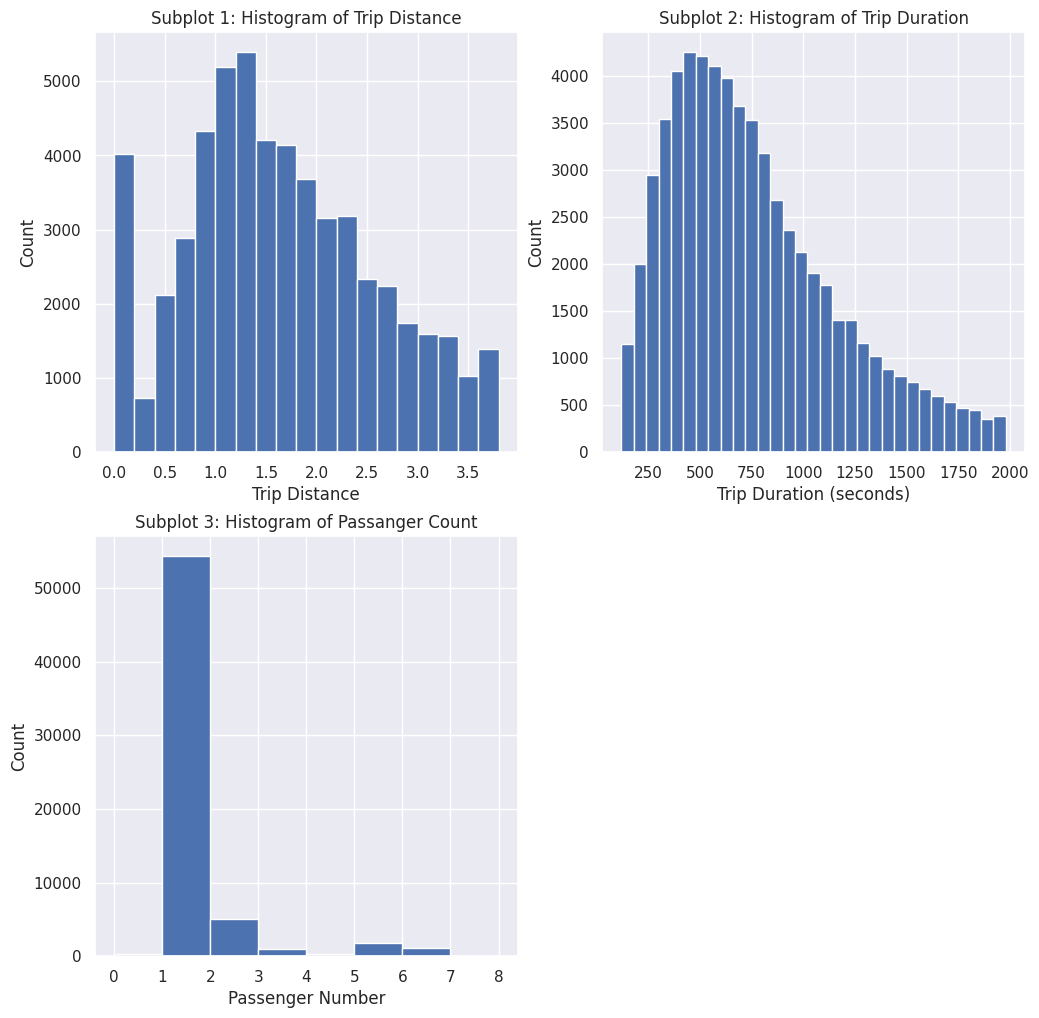

In [37]:
fig = plt.figure(figsize=(12,12))

# Create subplot 1
ax1 = fig.add_subplot(221) #suplot 1
ax1.set_xlabel('Trip Distance')
ax1.set_ylabel('Count')
ax1.set_title('Subplot 1: Histogram of Trip Distance')

ax1 = plt.hist(df.trip_distance, bins=np.arange(0,4,0.2))

# Create subplot 2
ax2 = fig.add_subplot(222) #suplot 2
ax2.set_xlabel('Trip Duration (seconds)')
ax2.set_ylabel('Count')
ax2.set_title('Subplot 2: Histogram of Trip Duration')

ax2 = plt.hist(df.trip_duration_seconds, bins=np.arange(120,2000,60))

# Create subplot 3
ax3 = fig.add_subplot(223) #suplot 3
ax3.set_xlabel('Passenger Number')
ax3.set_ylabel('Count')
ax3.set_title('Subplot 3: Histogram of Passanger Count')

ax3 = plt.hist(df.passenger_count, bins=np.arange(0,9,1))

**Trip Duration** terlihat berbentuk lonceng miring ke kiri. Distribusi kali ini terlihat lebih mulus, terlihat dari sisi kanan kurva menurun secara merata. Kita selidiki lebih lanjut.

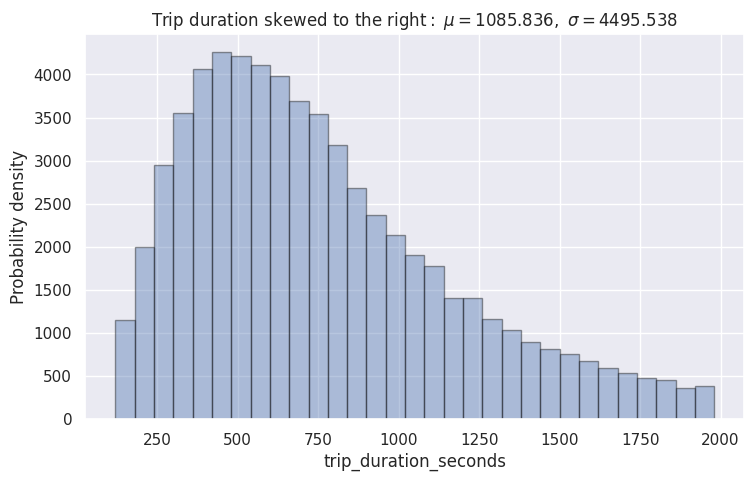

In [39]:
from scipy.stats import norm
# Mean
mu = df.trip_duration_seconds.mean()

# Standard deviation
sigma = df.trip_duration_seconds.std()
bins = np.arange(120,2000,60)
fig = plt.figure(figsize=(8.5, 5))
plt.hist(df.trip_duration_seconds, edgecolor = 'black', lw = 1, alpha = .40, bins=np.arange(120,2000,60))
# Normal Distribution
y = norm.pdf(bins, mu, sigma)
#plt.plot(b, y, 'r--', linewidth=2)
plt.xlabel('trip_duration_seconds')
plt.ylabel('Probability density')

plt.title(r'$\mathrm{Trip\ duration\ skewed \ to \ the \ right:}\ \mu=%.3f,\ \sigma=%.3f$'%(mu,sigma))
plt.grid(True)

plt.show()

# No.2 Pick Up Location Ranking

Saya telah merancang pendekatan algoritma/analitis untuk mengurutkan lokasi penjemputan berdasarkan metrik evaluasi kustom yang saya hitung.

Karakteristik-karakteristik penting yang dipertimbangkan saat memilih lokasi penjemputan:
- Jarak perjalanan bukanlah indikator yang baik untuk menilai perjalanan yang baik. Semakin jauh sopir mengantarkan penumpang, semakin jauh pula ia harus kembali ke tempat penjemputan sendirian, terutama jika perjalanan membawa mereka ke distrik atau kota yang berbeda.

- Fare amount adalah karakteristik yang paling penting dalam sebuah perjalanan. Sebagai sopir yang mendapatkan komisi, ia akan mendapatkan bagian yang cukup besar dari fare amount tersebut, bahkan jika penumpang tidak memberikan tip.

- Karakteristik kedua yang paling penting adalah jumlah tip yang diberikan oleh penumpang. Alasannya jelas, semakin banyak tip yang diterima, semakin besar pula penghasilannya.

- Aspek ketiga yang dianggap penting adalah durasi perjalanan. Semakin lama perjalanan berlangsung, semakin besar pula jumlah total pendapatan yang akan diterima oleh sopir. Perlu diperhatikan bahwa kami melihat dalam bagian EDA bahwa fare amount dan durasi perjalanan tidak selalu memiliki hubungan linear, karena ada sekelompok besar perjalanan yang tidak berkorelasi linear dalam durasi perjalanan dan fare ampunt.

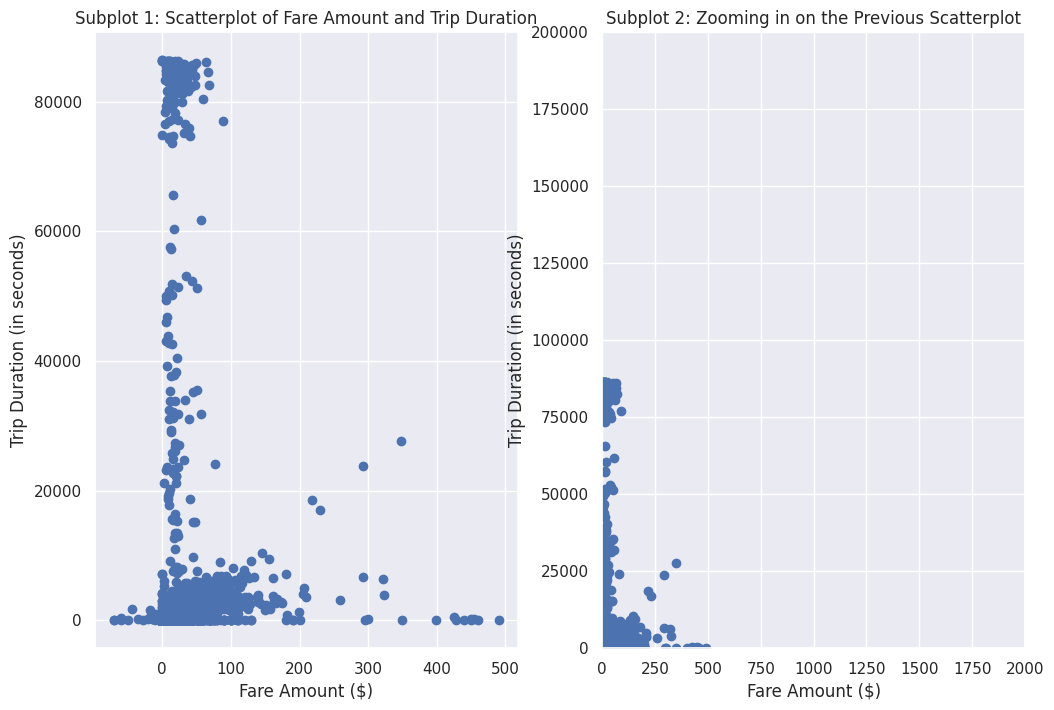

In [40]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(121) #this is suplot 1
ax1.set_xlabel('Fare Amount ($)')
ax1.set_ylabel('Trip Duration (in seconds)')
ax1.set_title('Subplot 1: Scatterplot of Fare Amount and Trip Duration')
ax1 = plt.scatter(df.fare_amount, df.trip_duration_seconds)

# zoom
ax2 = fig.add_subplot(122) #this is suplot 2
ax2.set_xlabel('Fare Amount ($)')
ax2.set_ylabel('Trip Duration (in seconds)')
ax2.set_xlim(0, 2000)
ax2.set_ylim(0, 200000)
ax2.set_title('Subplot 2: Zooming in on the Previous Scatterplot')

ax2 = plt.scatter(df.fare_amount, df.trip_duration_seconds)

Berikut formula yang dibuat:

Best_trip_metric = 0.5 * (Scaled Fair Amount) + 0.3 * (Scaled Tip Amount) + 0.2 * (Scaled Trip Duration Amount)

Metrik ini adalah metrik berbobot untuk memasukkan daftar prioritas karakteristik yang agak subyektif, yang memungkinkan karakteristik trips yang lebih penting untuk mendapatkan bobot yang lebih berat.

Kemudian, akhirnya mengambil kumpulan data, mengelompokkan berdasarkan setiap lokasi pengambilan yang ada, dan menghitung metrik **Best_trip_metric** rata-rata, lalu diberikan peringkat dalam urutan menurun, dan didapatkan lokasi terbaik.

In [41]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

best_trip_features_scaled = pd.DataFrame(std_scaler.fit_transform(df[["fare_amount", "tip_amount", "trip_duration_seconds"]]))

best_trip_features_scaled.columns = ["fare_amount", "tip_amount", "trip_duration_seconds"]
best_trip_features_scaled.describe()

,fare_amount,tip_amount,trip_duration_seconds
count,68211.000000,68211.000000,68211.000000
mean,0.000000,0.000000,0.000000
std,1.000007,1.000007,1.000007
min,-6.429354,-4.140290,-0.241538
25%,-0.542207,-0.700698,-0.145220
50%,-0.230404,-0.176570,-0.089386
75%,0.237301,0.390144,-0.008194
max,35.144444,72.094178,18.976103


Semua terlihat bagus, Mean 0, std dev 1. Terlihat sudah normal

In [42]:
best_trip_features_scaled.head()

,fare_amount,tip_amount,trip_duration_seconds
0,-0.126469,0.619450,-0.094502
1,-0.438273,0.164114,-0.151226
2,-0.698109,-0.065192,-0.157009
3,-0.750076,-0.143812,-0.163905
4,-0.787196,-0.700698,-0.161903


In [43]:
my_best_trip_ranking = 0.5 * best_trip_features_scaled["fare_amount"] + 0.3 * best_trip_features_scaled["tip_amount"] + 0.2 * best_trip_features_scaled["trip_duration_seconds"]

df["best_trip_ranking"] = my_best_trip_ranking

In [44]:
PULocation_aggregatedRanking = df.groupby('PULocationID').mean()['best_trip_ranking']
PULocation_aggregatedRanking

PULocationID
1      7.673968
3     -0.019873
7     -0.066630
9      0.671454
10     0.215735
         ...   
261    2.047408
262    0.239292
263   -0.000461
264   -0.118224
265    1.554520
Name: best_trip_ranking, Length: 226, dtype: float64

In [45]:
PULocation_aggregatedRanking.sort_values(ascending=False)

PULocationID
1      7.673968
141    5.833354
23     2.328770
230    2.195160
229    2.048175
         ...   
145   -0.283218
193   -0.349528
122   -0.388961
27    -0.602188
207   -0.778432
Name: best_trip_ranking, Length: 226, dtype: float64

**Hasil analisis lokasi pick up terbaik**

TOP 5 ID Lokasi Terbaik:

1. 1
2. 141
3. 23
4. 230
5. 229

TOP 5 ID Lokasi Terburuk:

1. 145
2. 193
3. 122
4. 27
5. 207

Jadi, lokasi pick up terbaik ada di **Lokasi ID 1**